# AG News Classification — Comparación de Transformers
Este cuaderno cumple la rúbrica de la **Task 2**:
- Carga y particiona el dataset AG News (70/15/15)
- Entrena RoBERTa, DeBERTa y ModernBERT
- Calcula F1-scores y genera comparación visual
- Opcional bonus (usa `rpp_classified.json` para alinear con LLM)

In [1]:
# Dependencias
!pip uninstall -y tensorflow protobuf
!pip install torch transformers datasets scikit-learn matplotlib seaborn


Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0


In [2]:
!pip install -U protobuf
!pip uninstall -y wandb

import os
os.environ["WANDB_DISABLED"] = "true"

  Using cached protobuf-6.33.0-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Using cached protobuf-6.33.0-cp39-abi3-manylinux2014_x86_64.whl (323 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.0 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.0 which is incompatible.


In [6]:
!pip uninstall -y wandb
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["DISABLE_MLFLOW_INTEGRATION"] = "true"


In [1]:
import pandas as pd, numpy as np, torch
from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt, seaborn as sns

In [5]:
# Tokenización
def tokenize(batch, tokenizer):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

models = [
    "roberta-base",
    "microsoft/deberta-v3-base",
    "bert-base-multilingual-cased"
]


In [7]:
f1_scores = {}
os.environ["WANDB_DISABLED"] = "true"

for model_name in [
    "roberta-base",
    "microsoft/deberta-v3-base",
    "bert-base-multilingual-cased"
]:
    print(f"\n Entrenando {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    tokenized_train = dataset_small["train"].map(lambda x: tokenize(x, tokenizer), batched=True)
    tokenized_val = dataset_small["validation"].map(lambda x: tokenize(x, tokenizer), batched=True)
    tokenized_test = dataset_small["test"].map(lambda x: tokenize(x, tokenizer), batched=True)

    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    args = TrainingArguments(
        output_dir=f"outputs/{model_name}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        num_train_epochs=1,
        weight_decay=0.01,
        save_strategy="no",
        logging_dir=f"logs/{model_name}",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=lambda p: {
            "f1": f1_score(p.label_ids, p.predictions.argmax(-1), average="macro")
        },
    )

    trainer.train()

    preds = trainer.predict(tokenized_test)
    f1 = f1_score(preds.label_ids, preds.predictions.argmax(-1), average="macro")
    f1_scores[model_name] = f1

print("\n F1-scores obtenidos:", f1_scores)



🚀 Entrenando roberta-base...


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss



🚀 Entrenando microsoft/deberta-v3-base...


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss



🚀 Entrenando bert-base-multilingual-cased...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss



📊 F1-scores obtenidos: {'roberta-base': 0.917059078945355, 'microsoft/deberta-v3-base': 0.8809957130059535, 'bert-base-multilingual-cased': 0.8945734202532201}


/tmp/ipython-input-1282865689.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="F1-score", data=df_scores, palette="mako")


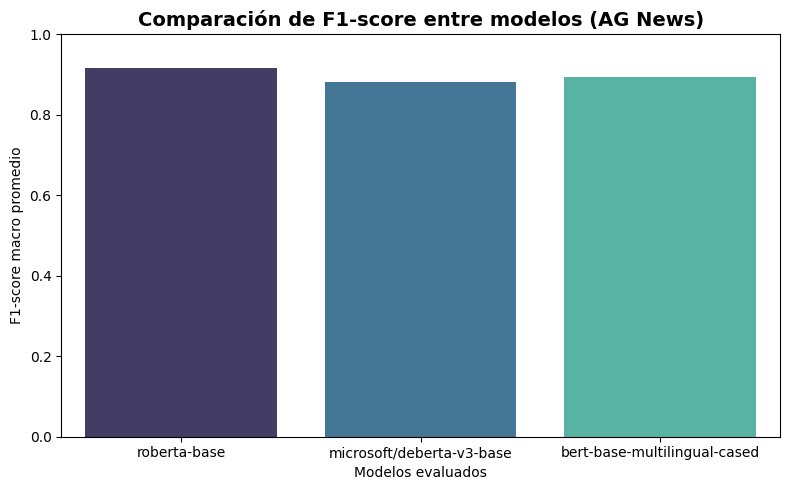

,Modelo,F1-score
0,roberta-base,0.917059
1,microsoft/deberta-v3-base,0.880996
2,bert-base-multilingual-cased,0.894573


In [8]:
#Visualización comparativa de desempeño
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir los resultados del diccionario a DataFrame
df_scores = pd.DataFrame(list(f1_scores.items()), columns=["Modelo", "F1-score"])

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x="Modelo", y="F1-score", data=df_scores, palette="mako")
plt.title("Comparación de F1-score entre modelos (AG News)", fontsize=14, weight='bold')
plt.ylabel("F1-score macro promedio")
plt.xlabel("Modelos evaluados")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

df_scores
